In [1]:
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr


import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [2]:
%load_ext autoreload
%autoreload 2

In [7]:
# Dataset suivi https://www.data.gouv.fr/fr/datasets/synthese-des-indicateurs-de-suivi-de-lepidemie-covid-19/
link = 'https://www.data.gouv.fr/fr/datasets/r/5c4e1452-3850-4b59-b11c-3dd51d7fb8b5'

In [48]:
from egbz.utils import *

In [8]:
df = pd.read_csv(link)

In [40]:
multi_df = df[['hosp', 'date', 'dep']].set_index(['dep', 'date'])

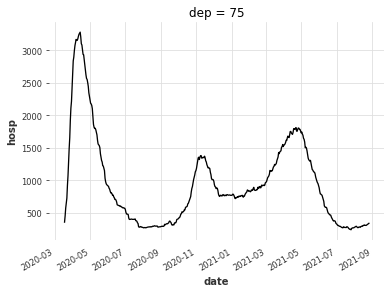

In [47]:
multi_df.to_xarray().hosp.loc[75, :].plot();

In [28]:
df[['date','dep','hosp']].set_index(['dep', 'date'], verify_integrity=True).to_xarray().hosp

<xarray.DataArray 'hosp' (dep: 102, date: 527)>
array([[ nan,  nan,  nan, ..., 140., 141., 139.],
       [ 10.,   9.,   4., ...,  60.,  62.,  62.],
       [  5.,   9.,   8., ..., 124., 115., 112.],
       ...,
       [ 94., 109., 123., ..., 129., 132., 134.],
       [  4.,   2.,   3., ...,  37.,  38.,  40.],
       [ 22.,  30.,  50., ...,  nan,  nan,  nan]])
Coordinates:
  * dep      (dep) object 62 63 64 65 66 67 68 ... '57' '58' '59' '60' '61' '62'
  * date     (date) datetime64[ns] 2020-03-18 2020-03-19 ... 2021-08-26

In [49]:
dataset = create_dataset(df, zone_col='dep', time_col='date', feat_cols='hosp')

In [50]:
dataset

<xarray.Dataset>
Dimensions:  (date: 527, dep: 101)
Coordinates:
  * dep      (dep) object '01' '02' '03' '04' '05' ... '972' '973' '974' '976'
  * date     (date) datetime64[ns] 2020-03-18 2020-03-19 ... 2021-08-26
Data variables:
    hosp     (dep, date) int64 2 2 2 4 8 17 22 29 33 49 ... 1 1 1 1 1 1 1 1 1 1

## Garbage

In [ ]:
ts['hosp_dep'].plot()

In [ ]:
ts = from_csv(link, cat_cols=['dep'], time_col='date', value_cols='hosp')
ts

In [ ]:
ts

In [ ]:
ts

In [ ]:
covid_df.query(' & '.join([f'{cat}=="{value}"' for cat, value in zip(['dep', 'lib_dep'], ['01', 'Ain'])]))

In [ ]:
time_col='date'
if time_col:
    datetime_series = pd.to_datetime(df[time_col])
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    df = df.set_index(datetime_index)
    df.drop(time_col, axis=1, inplace=True)

In [ ]:
categories = itertools.product(*['dep', 'lib_dep'])
for x in categories:
    print(str(x))

In [ ]:
cat_cols = ['lib_dep']
value_cols = ['hosp']
categories = itertools.product(*[df[cat].unique() for cat in cat_cols])
d = {f'{col}_{"_".join([x for x in cat])}': 
     df.query(' & '.join([f'{cat_name}=="{cat_value}"'
                            for cat_name, cat_value in zip(cat_cols, [x for x in cat])
                            ])
     )[col]
    for cat in categories
    for col in value_cols
}
pd.DataFrame(d)

In [ ]:
from egbz.utils import *

In [ ]:
plt.plot([1, 2 ,3]);

In [ ]:
df = df.query('dep=="01" | dep=="02"')

In [ ]:
ts = from_df(df, cat_cols=['dep', 'lib_dep'], time_col='date', value_cols=['hosp', 'rea'])

In [ ]:
ts.plot()

In [ ]:
import itertools

for x in itertools.product(*[df[cat].unique() for cat in ['dep', 'lib_dep']]):
    '_'.join([str(y) for y in x])

In [ ]:
'test'
'trolol'

In [ ]:
covid_df.query(' & '.join([f'{cat}=="{value}"' for cat, value in zip(['dep', 'lib_dep'], ['01', 'Ain'])]))

In [ ]:
covid_df.query('dep=="01"')

In [ ]:
df = covid_df
df

In [ ]:
ts.pd_dataframe()

In [ ]:
covid_df = pd.read_csv(link)

In [ ]:
covid_df

In [ ]:
d = {f'{cat}_{col}': cat for cat in covid_df['dep'].unique() for col in ['hosp']}
d

In [ ]:
TimeSeries.from_dataframe(covid_df[['dep','hosp']].query('dep=="01"'))

In [ ]:
from darts import TimeSeries

In [ ]:
TimeSeries.from_dataframe(covid_df[covid_df['dep']=='01'],
                         time_col='date',
                         value_cols='hosp')

In [ ]:
covid_df.keys()

In [ ]:
covid_df.groupby('dep').

In [ ]:
paris_df = covid_df.query('dep==75')

In [ ]:
df = covid_df[['date', 'dep', 'dchosp', 'hosp', 'rea']]
datetime_series = pd.to_datetime(df['date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
df=df.set_index(datetime_index)
df.drop('date',axis=1,inplace=True)
df

In [ ]:
def series_train_test(
    data=covid_df, features=['hosp'],
    timestamp=pd.Timestamp('2021-01-01'), departement=75
):
    # Convert the index into a datetime index
    df = covid_df.query(f'dep=={departement}')[['date'] + features]
    datetime_series = pd.to_datetime(df['date'])
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    df=df.set_index(datetime_index)
    df.drop('date',axis=1,inplace=True)
    
    #
    time_series = {}
    train = {}
    test = {}
    for feature in features:
      series[feature] = TimeSeries.from_dataframe(df[[feature]]) 
      train[feature], test[feature] = time_series[feature].split_before(
          pd.Timestamp(timestamp)
      )
        
    return series, train, test

In [ ]:
time_series, train, test = time_series_train_test(data=paris_df, features['rea'])

In [ ]:
covid_df

In [ ]:
time_series['dchosp']

In [ ]:
train['hosp'].plot(label='train')
test['hosp'].plot(label='test')

In [ ]:
paris_df = covid_df.query('dep==75')[['date', 'TO', 'hosp', 'rea', 'dchosp']]

In [ ]:
paris_df.plot();

In [ ]:
paris_df.info()

In [ ]:
datetime_series = pd.to_datetime(paris_df['date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
df=paris_df.set_index(datetime_index)
df.drop('date',axis=1,inplace=True)
df

In [ ]:

df.plot();

In [ ]:
train, val = series.split_before(pd.Timestamp('2021-01-01'))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

In [ ]:
naive_model = NaiveSeasonal(K=158)
naive_model.fit(train)
naive_forecast = naive_model.predict(300)

series.plot(label='actual')
naive_forecast.plot(label='naive forecast (K=158)')
plt.legend();

In [ ]:
mae(naive_model.predict(220), val)

In [ ]:
!pip install optuna

In [ ]:
import optuna

In [ ]:
def objective(trial):
  naive_model = NaiveSeasonal(K=trial.suggest_int('K', 1, 289))
  naive_model.fit(train)
  return mae(naive_model.predict(220), val)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=289, n_jobs=-1)


In [ ]:
study.best_trial

In [ ]:
plot_acf(train, m = 30, alpha = .05)

In [ ]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print('model {} obtains MAE: {:.2f}%'.format(model, mae(val, forecast)))

eval_model(NaiveSeasonal(K=158))
eval_model(ExponentialSmoothing())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())

In [ ]:
expo_model = ExponentialSmoothing()
expo_model.fit(train)
expo_forecast = expo_model.predict(len(val))
series.plot(label='Ground truth')
expo_forecast.plot(label='Prediction')
mae(y_pred, val)

In [ ]:
def objective(trial):
  theta_model = Theta(theta=trial.suggest_float('theta', -10, 10))
  theta_model.fit(train)
  theta_forecast = theta_model.predict(len(val))
  return mae(theta_forecast, val)

theta_study = optuna.create_study(direction='minimize')
theta_study.optimize(objective, n_trials=500, n_jobs=-1)

In [ ]:
theta_study.trials_dataframe().sort_values('value')

In [ ]:
theta_model = Theta(theta=1.422738)
theta_model.fit(train)
theta_forecast = theta_model.predict(len(val))
theta_forecast = theta_model.predict(len(val))
series.plot(label='Ground truth')
theta_forecast.plot(label='Prediction')
mae(y_pred, val)

In [ ]:
df.keys()

In [ ]:
time_series = {}
train_val = {}
for feature in df.keys():
  time_series[feature] = Scaler().fit_transform(TimeSeries.from_dataframe(df[[feature]]))
  train_val[feature] = time_series[feature].split_before(pd.Timestamp('2021-01-01'))

In [ ]:
time_series, train, test = time_series_train_val(timestamp='2021-04-01', features=['hosp', 'rea'])

In [ ]:
model_air = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=12)

In [ ]:
model_air.fit(train['hosp'], verbose=True)

In [ ]:
air_forecast = model_air.predict(12)
plt.figure(figsize=(24,16))
time_series['hosp'].plot(label='Ground truth')
air_forecast.plot(label='Prediction')
mape(air_forecast, time_series['hosp'])

In [ ]:
series, train, test = time_series_train_val(
    timestamp=pd.Timestamp('2021-07-01'),
    features=['hosp', 'rea', 'dchosp']
)

In [ ]:
train_series, train, val = time_series_train_val(
    data=train,
    timestamp=pd.Timestamp('2021-01-01'),
    features=['hosp', 'rea', 'dchosp']
)

In [ ]:
test['hosp'].plot()

In [ ]:
my_model = TransformerModel(
    input_chunk_length = 20,
    output_chunk_length = 10,
    batch_size = 16,
    n_epochs = 50,
    model_name = 'air_transformer',
    log_tensorboard=True,
    nr_epochs_val_period = 10,
    d_model = 32,
    nhead = 16,
    num_encoder_layers = 3,
    num_decoder_layers = 3,
    dim_feedforward = 512,
    dropout = 0.1,
    activation = "relu",
    force_reset=True
)

In [ ]:
my_model.fit(series=train['hosp'], val_series=val['hosp'], verbose=True)

In [ ]:
pred = my_model.predict(n=10, series=train['hosp'])
series['hosp'].plot('label')
pred.plot(label='prediction')

In [ ]:
backtest = model_cov.historical_forecasts(series_air_scaled,
                                              past_covariates=air_covariates,
                                              start=0.6,
                                              forecast_horizon=12,
                                              stride=1,
                                              retrain=False,
                                              verbose=True)

series_air_scaled.plot(label='actual')
backtest_cov.plot(label='forecast')
plt.legend();
print('MAPE (using covariates) = {:.2f}%'.format(mape(series_air_scaled, backtest_cov)))

In [ ]:
#this function evaluates a model on a given validation set for n time-steps
def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(8,5))
    series.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_series)))
    plt.legend();

eval_model(my_model, 2, series['hosp'], test['hosp'])
